<a href="https://colab.research.google.com/github/joserobertofox/datascience/blob/main/MVP2_DL_Vis%C3%A3o_Computacional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MVP de Machine Learning & Analytics - Deep Learning - Visão Computacional**
## **Aluno: José Roberto Assis Silva**

## **1. Definição do Problema**

Este conjunto de dados foi criado com a finalidade de usá-lo em um drone e mapear/detectar doenças no campo de milho. Este conjunto de dados contém 4117 imagens de folhas doentes e saudáveis, distribuidas em 1550 doentes e 2567 saudáveis. Vamos criar um modelo que consiga mapear estas imagens e classificar.


In [113]:
# Configuração para tratamento de erros
import warnings
warnings.filterwarnings("ignore")

In [114]:
#Importando as bibliotecas
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import models
from keras import optimizers
import os
from sklearn.model_selection import train_test_split
import shutil
import random
import math
import numpy as np
import zipfile
import pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from datetime import datetime
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report
import sklearn.metrics as skm
import itertools
import numpy as np
import matplotlib.pyplot as plt
import missingno as ms # para tratamento de missings
!pip install gdown
import gdown
import os
import zipfile

In [115]:
#Função para imprimir a Matriz de Confusão
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Esta função imprime e plota a matriz de confusão.
    A normalização pode ser aplicada definindo `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de confusão normalizada")
    else:
        print('Matriz de confusão sem normalização')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Label real')
    plt.xlabel('Label predito')

## **2. Carga do Dataset**

Nesta etapa iremos um arquivo zipado que está no Google Drive e extrairemos a imagens de folhas doentes e folhas saudáveis. Posteriormente vamos criar um dataframe com as informações de cada imagem.

In [116]:
file_id = "1ETlFcANrOKUuTsZ_8aPuys_YUbxiXUg5"
url = f"https://drive.google.com/uc?id={file_id}"

folder_path = "./dataset"  # especifique a pasta onde baixara o arquivo
os.makedirs(folder_path, exist_ok=True) # cria a pasta de destino se necessário

output = "dataset/Corn.zip"  # especifique o nome do arquivo e a extensão do mesmo
gdown.download(url, output)

Downloading...
From: https://drive.google.com/uc?id=1ETlFcANrOKUuTsZ_8aPuys_YUbxiXUg5
To: /content/dataset/Corn.zip
100%|██████████| 39.6M/39.6M [00:00<00:00, 154MB/s]


'dataset/Corn.zip'

In [117]:
destination = 'dataset/images' # path onde se encontra o arquivo 'Corn.zip'

os.makedirs(destination,exist_ok=True) # cria a pasta de destino se necessário

with zipfile.ZipFile(output,'r') as zip_ref:
    zip_ref.extractall(destination)

In [118]:
path='dataset/images/Corn/diseased/' # Pasta onde estão as de imagens de folhas doentes
path1='dataset/images/Corn/healthy/' # Pasta onde estão as de imagens de folhas saudáveis
print(f"Temos um total de {len(os.listdir(path))} imagens de folhas de milho doentes para o treinamento e avaliação do modelo de deep learning")
print(f"Temos um total de {len(os.listdir(path1))} imagens de folhas de milho saudáveis para o treinamento e avaliação do modelo de deep learning")
print(f"Temos um total de {len(os.listdir(path))+len(os.listdir(path1))} imagens de folhas de milho para o treinamento e avaliação do modelo de deep learning")

Temos um total de 1550 imagens de folhas de milho doentes para o treinamento e avaliação do modelo de deep learning
Temos um total de 2567 imagens de folhas de milho saudáveis para o treinamento e avaliação do modelo de deep learning
Temos um total de 4117 imagens de folhas de milho para o treinamento e avaliação do modelo de deep learning


In [119]:
print(f"Primeiras 20 imagens de folhas de milho doentes: \n {os.listdir(path)[:20]}") # Listando as 20 primeiras imagens
print(f"Primeiras 20 imagens de folhas de milho saudáveis: \n {os.listdir(path1)[:20]}") # Listando as 20 primeiras imagens

Primeiras 20 imagens de folhas de milho doentes: 
 ['a46e1d1c-13bb-419b-b69c-a03dec0d53c1___RS_NLB 3790.JPG', 'J_170824_1329560.jpg', 'J_170824_1318491.jpg', '2ea20efb-b8d6-4ff9-8e72-418fd4a239f0___RS_NLB 4022.JPG', '5ea1de01-683f-4080-a341-6eafb3d41bc4___RS_NLB 4154.JPG', 'J_170823_1343403.jpg', 'J_170824_1318096.jpg', '845ece89-ec44-4727-b5f4-8df8407b6fea___RS_NLB 4039 copy.jpg', '6c9a344f-a84c-4b4f-8b0b-498fb9d39e62___RS_NLB 3926.JPG', '30f5e05c-9d93-47d1-b3b4-9358de08d63f___RS_NLB 3863.JPG', 'f3a574c8-043a-4804-bdba-addb50450720___RS_NLB 3553 copy.jpg', 'a3b588f0-1c34-4a1e-ad47-c2202a896173___RS_NLB 3834.JPG', 'ed3a9e57-8d8c-471c-bb5a-7ef5a205bc19___RS_NLB 3711.JPG', 'J_170823_1344077.jpg', 'd1dc8657-22f9-42f8-a467-0dc1f0e2ed2e___RS_NLB 3643.JPG', 'J_170824_1318160.jpg', 'c5e23efb-7f78-47c4-8de8-a00d5a925af1___RS_NLB 3626.JPG', '8602c5b9-6f3c-455d-8a8a-c80f237395bc___RS_NLB 3659.JPG', '87705bdf-957a-4abb-b8b6-159d64de4e02___RS_NLB 3985.JPG', '5d8533b8-c57e-49af-aa9e-e4ab9f28f92b___

In [120]:
images =os.listdir(path)

labels, heights, widths, channels, filesize = [], [], [], [], []

# Loop que percorre cada uma das imagens de folhas doentes extraídas
for fname in images:

    labels.append("diseased")
    img_shape = mpimg.imread(path+fname).shape
    heights.append(img_shape[0])
    widths.append(img_shape[1])
    channels.append(img_shape[2])
    filesize.append(os.path.getsize(path+fname))

# Criação do dataset
df = pd.DataFrame({'images': images, 'class': labels, 'height': heights,
                         'width': widths, 'channels': channels, 'filesize': filesize})

# Imprimindo as últimas 20 linhas do dataframe com folhas doentes
df.tail(20)

,images,class,height,width,channels,filesize
1530,d8a2c04c-5d2b-485c-aaff-1440c0cd65e1___RS_NLB ...,diseased,256,256,3,10672
1531,a1239833-7c07-4f71-b81a-44bbdf370f1a___RS_NLB ...,diseased,256,256,3,14681
1532,J_170824_13184210.jpg,diseased,256,256,3,8113
1533,9c7b6913-1640-4ee7-85b8-5e457fab550e___RS_NLB ...,diseased,256,256,3,14148
1534,1ae12a5e-1f91-4aec-a508-b6e05d78a8ff___RS_NLB ...,diseased,256,256,3,12695
1535,5ab0a55a-509c-4c16-8e16-cb2880f0677d___RS_NLB ...,diseased,256,256,3,15107
1536,3b8446bd-30df-4ff8-87e3-bcddae3b4e7a___RS_NLB ...,diseased,256,256,3,15244
1537,J_170824_13184010.jpg,diseased,256,256,3,6184
1538,61e17b1e-9858-4d1f-b51e-a017eaaeae08___RS_NLB ...,diseased,256,256,3,11415
1539,J_170823_1344135.jpg,diseased,256,256,3,6058


In [121]:
labels1, heights1, widths1, channels1, filesize1 = [], [], [], [], []

images1 =os.listdir(path1)

# Loop que percorre cada uma das imagens de folhas saudáveis extraída
for fname in images1:

    labels1.append("healthy")
    img_shape1 = mpimg.imread(path1+fname).shape
    heights1.append(img_shape1[0])
    widths1.append(img_shape1[1])
    channels1.append(img_shape1[2])
    filesize1.append(os.path.getsize(path1+fname))

# Criação do dataset
df1 = pd.DataFrame({'images': images1, 'class': labels1, 'height': heights1,
                         'width': widths1, 'channels': channels1, 'filesize': filesize1})

# Imprimindo as últimas 20 linhas do dataframe com folhas saudáveis
df1.tail(20)

,images,class,height,width,channels,filesize
2547,da7362e5-f442-44f3-aeb8-6523e0a2d9c1___R.S_HL ...,healthy,256,256,3,15462
2548,J_170824_1319291.jpg,healthy,256,256,3,7275
2549,ef061910-eea2-4ebb-9523-d2c0510e3031___R.S_HL ...,healthy,256,256,3,14275
2550,J_170824_1327011.jpg,healthy,256,256,3,9840
2551,53ed74e8-9420-429f-8f49-ad5c40eed3a7___R.S_HL ...,healthy,256,256,3,7991
2552,J_170824_1327018.jpg,healthy,256,256,3,7658
2553,f6c25b27-60b4-43fe-879d-355b39d0d6e5___R.S_HL ...,healthy,256,256,3,10562
2554,J_170824_13173622.jpg,healthy,256,256,3,7691
2555,J_170824_1318421.jpg,healthy,256,256,3,8262
2556,J_170824_1319062.jpg,healthy,256,256,3,6971


In [122]:
#Juntando os dois dataframes e imprimindo as últimas 20 linhas
df2 = pd.concat([df, df1], ignore_index = True)
df2.tail(20)

,images,class,height,width,channels,filesize
4097,da7362e5-f442-44f3-aeb8-6523e0a2d9c1___R.S_HL ...,healthy,256,256,3,15462
4098,J_170824_1319291.jpg,healthy,256,256,3,7275
4099,ef061910-eea2-4ebb-9523-d2c0510e3031___R.S_HL ...,healthy,256,256,3,14275
4100,J_170824_1327011.jpg,healthy,256,256,3,9840
4101,53ed74e8-9420-429f-8f49-ad5c40eed3a7___R.S_HL ...,healthy,256,256,3,7991
4102,J_170824_1327018.jpg,healthy,256,256,3,7658
4103,f6c25b27-60b4-43fe-879d-355b39d0d6e5___R.S_HL ...,healthy,256,256,3,10562
4104,J_170824_13173622.jpg,healthy,256,256,3,7691
4105,J_170824_1318421.jpg,healthy,256,256,3,8262
4106,J_170824_1319062.jpg,healthy,256,256,3,6971


healthy     2567
diseased    1550
Name: class, dtype: int64


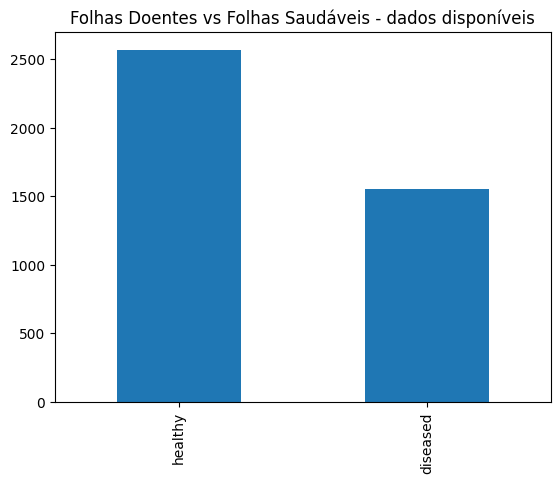

In [124]:
# Plotando gráfico de barra com as quantidades da classe target class
print((df2['class']).value_counts())
dogsVScats_count = df2['class'].value_counts().plot.bar(title='Folhas Doentes vs Folhas Saudáveis - dados disponíveis')

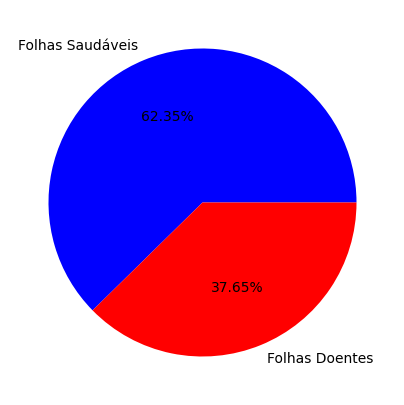

In [125]:
# Plotando gráfico de pizza com a distribuição da classe target class
fig, ax = plt.subplots(figsize=(5,5))
plt.pie(x=df2['class'].value_counts(),
        colors=["blue","red"],
        labels=["Folhas Saudáveis","Folhas Doentes"],
        autopct="%1.2f%%",
        )
plt.show()

Folhas Doentes


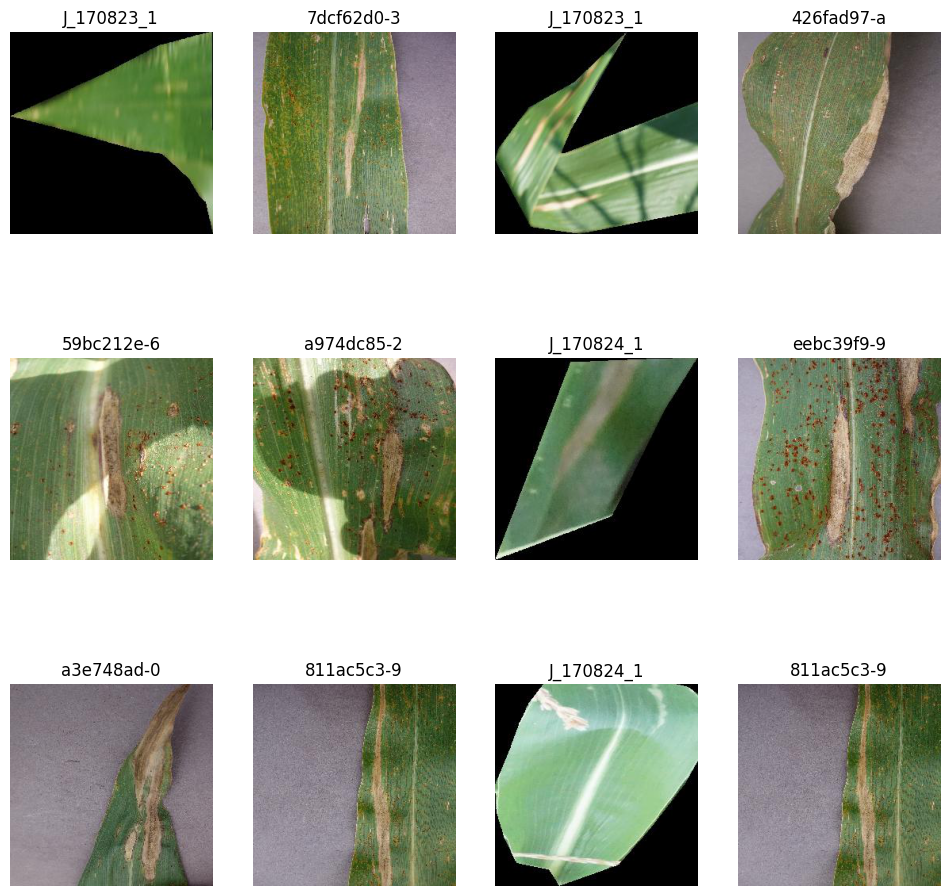

In [126]:
# Plotando 12 imagens de folhas doentes
fig = plt.gcf()
fig.set_size_inches(3*4, 3*4)

# Visualizando apenas 12 imagens
print("Folhas Doentes")
for i in range(12):

    sample = np.random.choice(images)
    img_path =path+sample
    sp = plt.subplot(3, 4, i + 1)
    sp.axis('Off')
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.title(sample[:10])

plt.show()

Folhas Saudáveis


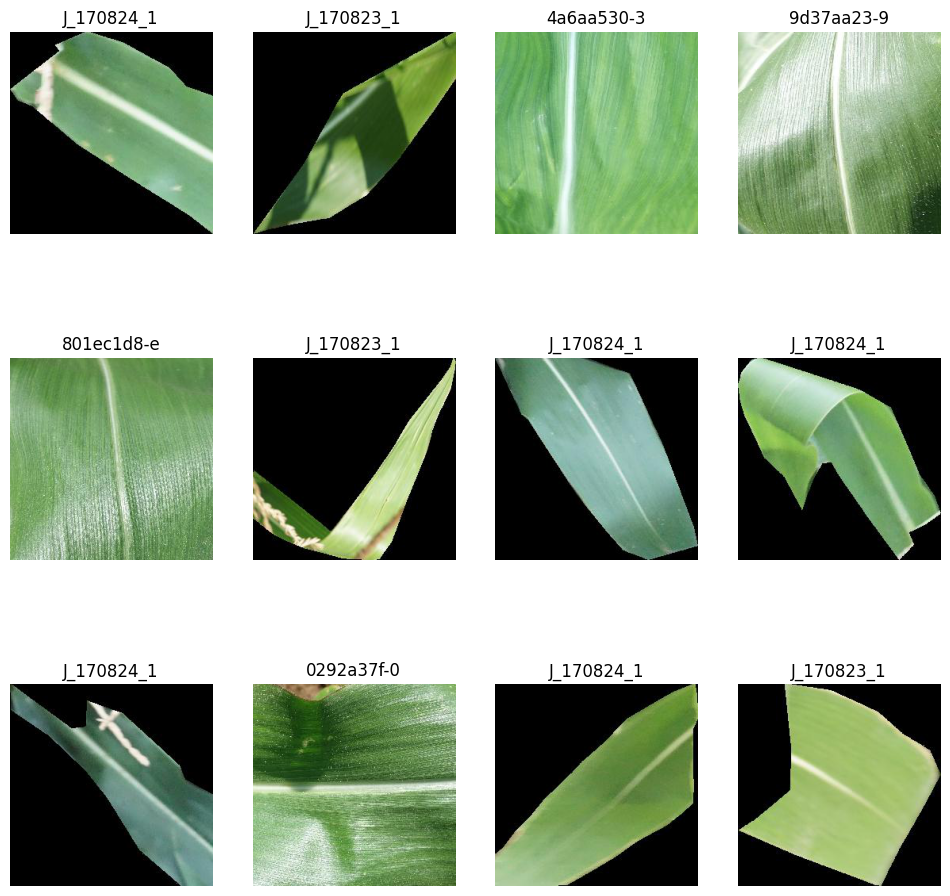

In [127]:
# Plotando 12 imagens de folhas saudáveis
fig = plt.gcf()
fig.set_size_inches(3*4, 3*4)

# Visualizando apenas 12 imagens
print("Folhas Saudáveis")
for i in range(12):

    sample = np.random.choice(images1)
    img_path =path1+sample
    sp = plt.subplot(3, 4, i + 1)
    sp.axis('Off')
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.title(sample[:10])

plt.show()

Movendo todas as imagens para uma só pasta

In [128]:
path2 = 'dataset/images/Corn/imagesall/' # Path para onde vão ser movidas todas as imagens'
os.makedirs(path2,exist_ok=True) # Cria a pasta para onde moveremos todas as imagens, se necessário

In [129]:
# Movendo as imagens para uma pasta comum
for f in images: # Pega cada item da lista de imagens doentes e move para a pasta imagesall
    os.rename(path + f, path2 + f)


for f in images1: # Pega cada item da lista de imagens doentes e move para a pasta imagesall
    os.rename(path1 + f, path2 + f)

imagesall = os.listdir(path2)
print(f"Temos um total de {len(os.listdir(path2))} imagens de folhas de milho doentes e saudáveis para o treinamento e avaliação do modelo de deep learning")

Temos um total de 4117 imagens de folhas de milho doentes e saudáveis para o treinamento e avaliação do modelo de deep learning


## **3. Pré-Processamento dos Dados**

### 3.1. Separação em Conjunto de Treino e Conjunto de Teste
Vou utilizar uma técnica de amostragem usando um conjunto teste ou conjunto de validação que é uma amostra de dados que não será utilizada na construção do modelo final. Será utilizada somente no final para validar se a construção do modelo foi bem sucedida e também para termos uma análise do modelo com dados ainda não utilizados. Criarei um conjunto de dados com 80% do dataset para criarmos o modelo e guardarei 20% para teste de validação, usando a estratégia train-test-split.

In [130]:
# Separação em Conjunto Treino e Teste
train, test =train_test_split(df2[['images' , 'class']] ,test_size=0.2 ,random_state=42 , shuffle=True)

#Visualizando a divisão dos dados

print("##### Conjunto de Treino: #####")
print(train)
print("##### Conjunto de Teste #####")
print(test)

##### Conjunto de Treino: #####
                                                 images     class
2077                               J_170823_1344554.jpg   healthy
468   311621c2-ce96-4e4d-ae49-b303619e1f9f___RS_NLB ...  diseased
561   a3a57aa7-6785-48a8-9bb6-f2726d365f9f___RS_NLB ...  diseased
2251                              J_170824_13180910.jpg   healthy
3712                               J_170824_1318468.jpg   healthy
...                                                 ...       ...
3444  28ca7e31-0f73-4546-b234-98dcaa581d67___R.S_HL ...   healthy
466                                J_170824_1331078.jpg  diseased
3092                               J_170823_1345234.jpg   healthy
3772  d2d6eb51-8cff-426e-9ca1-6802f880b120___R.S_HL ...   healthy
860   2a4b3fe0-6858-459b-b620-cd01d0cd6333___RS_NLB ...  diseased

[3293 rows x 2 columns]
##### Conjunto de Teste #####
                                                 images     class
2648  9a11606d-02ed-43d3-af4b-da7414dfb4e7___R.S_HL ...

### 3.2. Preparação dos Dados
ImageDataGenerator é uma classe utilitária fornecida pelo TensorFlow para aumentar e pré-processar dados de imagens. É comumente usada em tarefas de deep learning, especialmente para classificação de imagens, para gerar imagens aumentadas (data augmentation) sob demanda durante o treinamento do modelo.

Utilizamos ainda o ImageDataGenerator para separar um conjunto de validação com 20% das amostras do conjunto de treino. É importante que o conjunto de validação não contenha as imagens de teste, tendo em vista que elas não deveriam ser conhecidas no momento do treinamento.

Veja que neste caso é usado o método flow_from_dataframe() para gerar imagens aumentadas a partir de um dataframe que aponta para as imagens originais. O método recebe parâmetros como o dataframe, o diretório com as imagens, o tamanho do lote (batch size) e o modo de classe (neste caso, binário porque são apenas duas classes), entre outros.

Importante ressaltar que o pré-processamento do teste não evolve o aumento de dados.

In [131]:
train_datagen=ImageDataGenerator(validation_split=0.2, #include validation split
                                 rescale = 1.0/255,
                                    rotation_range=40,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')

test_datagen=ImageDataGenerator(rescale=1./255)


train_generator=train_datagen.flow_from_dataframe(
    train , path2,
    target_size=(150,150),
    batch_size=50,
    class_mode='binary',
    x_col='images',
    y_col='class',
    subset='training' #training set
    )

val_generator=train_datagen.flow_from_dataframe(
    train ,path2,
    target_size=(150,150),
    batch_size=50,
    class_mode='binary',
    x_col='images',
    y_col='class',
    subset='validation' #validation set
    )

test_generator=test_datagen.flow_from_dataframe(
    test ,path2,
    target_size=(150,150),
    batch_size=50,
    class_mode='binary',
    x_col='images',
    y_col='class',)

Found 2635 validated image filenames belonging to 2 classes.
Found 658 validated image filenames belonging to 2 classes.
Found 824 validated image filenames belonging to 2 classes.


Found 1 validated image filenames belonging to 1 classes.


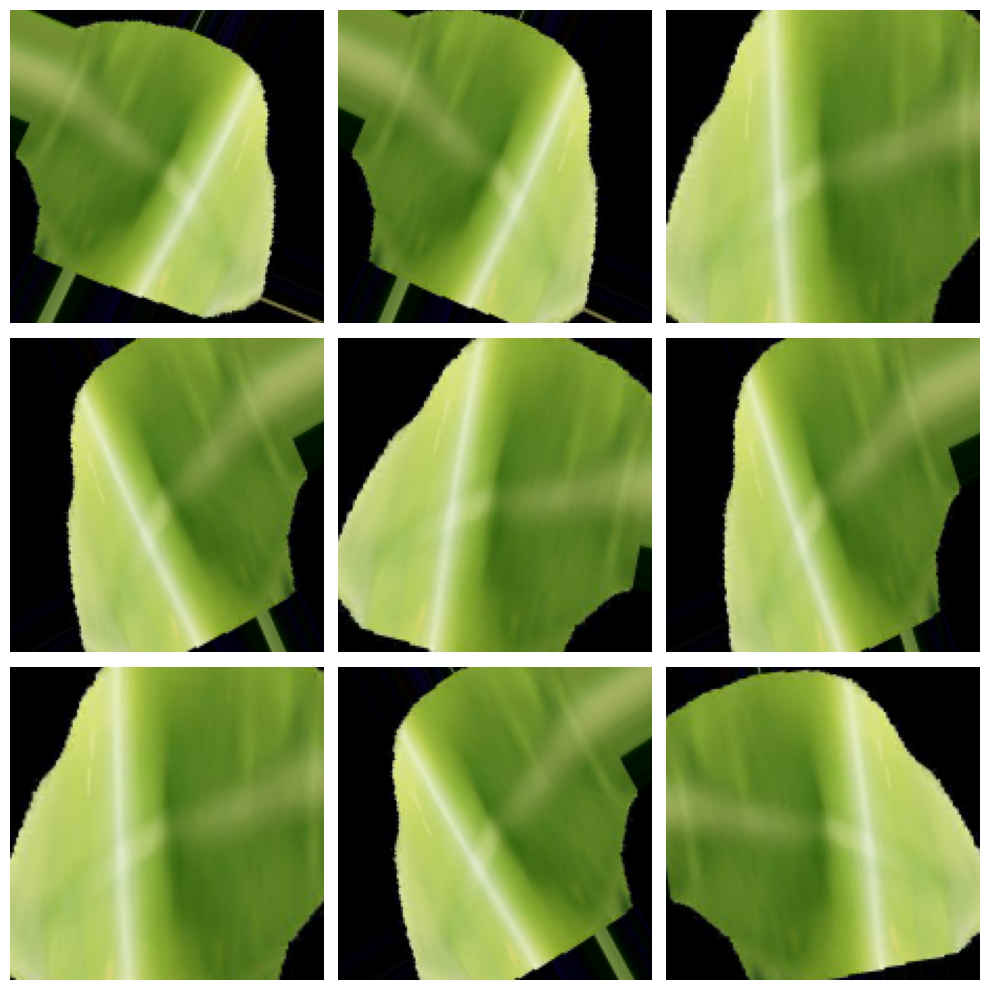

In [132]:
# Pegando um registro do dataframe
sample = df2.sample(n=1)

# Neste caso o tipo de classe é categorico, pois temos um exemplo com apenas uma classe
sample_generator = train_datagen.flow_from_dataframe(
    sample,
    path2,
    x_col='images',
    y_col='class',
    target_size=(150,150),
    class_mode='categorical'
)

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    for x_batch, y_batch in sample_generator:
        image = x_batch[0]
        plt.imshow(image)
        plt.axis('Off')
        break
plt.tight_layout()
plt.show()

## **4. Modelagem e Inferência**

### 4.1. Configuração de um modelo de deep learning usando uma rede neural convolucional (CNN) simples com a biblioteca Keras

Definição da arquitetura do modelo

Aqui é especificada uma camada convolucional 2D que possui 32 filtros, um tamanho de filtro de 3x3 que usa a função de ativação ReLU. O parâmetro input_shape define a forma das imagens de entrada para a rede. Na sequência são adicionadas camadas max-pooling com a mesma função de ativação.

In [133]:
model=models.Sequential()
model.add(layers.Conv2D(32 ,(3,3) , activation='relu' , input_shape=(150,150,3 ) ) )
model.add(layers.MaxPooling2D( (2,2)))

model.add(layers.Conv2D(64 , (3,3) , activation='relu'))
model.add(layers.MaxPooling2D( (2,2)))

model.add(layers.Conv2D(128 , (3,3) , activation='relu'))
model.add(layers.MaxPooling2D( (2,2)))

In [134]:
model.add(layers.Conv2D(128 , (3,3) , activation='relu'))
model.add(layers.MaxPooling2D( (2,2)))
model.add(layers.Flatten() )
model.add(layers.Dropout(0.25))
model.add(layers.Dense( 512 ,activation='relu' ))
model.add(layers.Dropout(0.25))
model.add(layers.Dense( 1 , activation='sigmoid' ) )

In [135]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 17, 17, 128)     

O método summary() é usado para exibir um resumo da arquitetura do modelo de rede neural. Ele fornece uma representação compacta das camadas do modelo e seus parâmetros, incluindo o número de parâmetros treináveis e a forma de saída de cada camada

### 4.2. Treinamento do modelo de deep learning

Compilação do modelo Keras com as configurações do treinamento
optimizer='adam': especifica o otimizador a ser usado durante o treinamento.

loss='binary_crossentropy': especifica a função de perda a ser usada durante o treinamento. Para problemas de classificação binária, onde a variável alvo tem apenas duas categorias, a perda binária de entropia cruzada é freqüentemente empregada.

metrics=['accuracy']: especifica as métricas de avaliação a serem usadas durante o treinamento e o teste.

model.compile(optimizer='adam', loss='binary_crossentropy' , metrics=['accuracy'])
O método fit_generator() inicia o processo de treinamento do modelo usando o gerador de dados para o treinamento train_generator e o gerador de dados de validação val_generator.

In [137]:
model.compile(optimizer='adam', loss='binary_crossentropy' , metrics=['accuracy'])

In [138]:
history=model.fit_generator(train_generator ,
                            steps_per_epoch=50,
                            epochs=10 ,
                            validation_data=val_generator ,
                            validation_steps=50)

Epoch 1/10
50/50 [==============================] - ETA: 0s - loss: 0.6432 - accuracy: 0.6394

50/50 [==============================] - 124s 2s/step - loss: 0.6432 - accuracy: 0.6394 - val_loss: 0.5554 - val_accuracy: 0.8176
Epoch 2/10
50/50 [==============================] - 90s 2s/step - loss: 0.4892 - accuracy: 0.7746
Epoch 3/10
50/50 [==============================] - 88s 2s/step - loss: 0.3559 - accuracy: 0.8475
Epoch 4/10
50/50 [==============================] - 90s 2s/step - loss: 0.3136 - accuracy: 0.8648
Epoch 5/10
50/50 [==============================] - 90s 2s/step - loss: 0.3033 - accuracy: 0.8612
Epoch 6/10
50/50 [==============================] - 89s 2s/step - loss: 0.3050 - accuracy: 0.8648
Epoch 7/10
50/50 [==============================] - 89s 2s/step - loss: 0.3817 - accuracy: 0.8455
Epoch 8/10
50/50 [==============================] - 89s 2s/step - loss: 0.2917 - accuracy: 0.8636
Epoch 9/10
50/50 [==============================] - 92s 2s/step - loss: 0.3134 - accuracy: 0.8571
Epoch 10/10
50/50 [==============================] - 90s 2s/step - loss: 0.3152 - accu

### 4.3. Execução do modelo treinado em um subconjunto das imagems de teste

Idealmente se deseja realizar a inferência sobre todo o conjunto de teste, porém para efeitos de agilidade, executamos apenas em um subconjunto de imagens.

In [ ]:
count = 0
y_pred = list()
y_true = list()
class_names = ['diseased', 'healthy']

# Loop do data generator de teste que contem as imagens
for batch in test_generator:

    count+=1

    # Condição de saída do loop. Só executaremos o modelo em algumas imagens
    if count == 2:
        break

    else:

        # Pegando a imagem e o label
        images = batch[0]
        labels = batch[1]

        # Previsão
        predictions = model.predict(imagesall)

        # Visualização da imagem
        for i in range(len(images)):

            image = images[i]
            label = labels[i]
            prediction = predictions[i]

            # Converte o array de previsão para visualizar a classe e a probabilidade
            predicted_class = np.argmax(prediction)
            probability = prediction[predicted_class]
            label = class_names[int(label)]
            y_true.append(label)

            # Faz o DE-PARA da probabilidade com o tipo de classe da previsão
            class_name = 'diseased' if prediction >= 0.5 else 'healthy'
            y_pred.append(class_name)

            # Configura a saída das imagens que serão visualizadas
            plt.imshow(images[i])
            plt.axis('Off')
            plt.show()

            # Imprime os resultados da classificação das images
            print("Label: ", label)
            print("Previsão: ", class_name)
            print("Probabilidade: ", probability)

### 4.4. Avaliação do Modelo de Deep Learning

#### 4.4.1. Acurácia do modelo nos dados de teste

In [ ]:
loss, accuracy = model.evaluate_generator(test_generator)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

#### 4.4.2. Visualização de métricas da avaliação do modelo
Métricas de performance do modelo no subconjunto das imagens de teste

In [ ]:
accuracy = skm.accuracy_score(y_true, y_pred)
precision = skm.precision_score(y_true, y_pred, average='weighted')
recall = skm.recall_score(y_true, y_pred, average='weighted')
f1score = skm.f1_score(y_true, y_pred, average='weighted')

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1score)

#### 4.4.3. Matriz de confusão para identificar onde o modelo de deep learning acertou e errou na classificação do subconjunto de imagens de teste

In [ ]:
cnf_matrix = confusion_matrix(y_true, y_pred, labels=class_names)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix,
                      classes=['cat',
                               'dog'],
                      normalize= False,
                      title='Matriz real x predição')

## **5. Exportando o Modelo para Posterior Uso**


#### 5.5.1. Salvando o modelo de deep learning que foi treinado

In [ ]:
# obtendo a data e hora atual
now = datetime.now()

# Definição do formato
format = '%Y-%m-%dT%H%M'

# Converter a data e hora em uma string com o formato especificado
formatted_datetime = now.strftime(format)

path_model = 'datasets/dogs_vs_cats/trained_models'

name_model = 'trained_model_' + formatted_datetime + '.h5'

# salvando o modelo
model.save("%s/%s" % (path_model, name_model))
print("Modelo salvo com o nome: ", name_model)

## **6. Teste do Modelo Exportado**


#### 6.6.1. Carregando o Modelo Salvo

In [ ]:
loaded_model = keras.models.load_model("%s/%s" % (path_model, name_model))
print("Modelo %s carregado com sucesso" % (name_model))

#### 6.6.2. Execução do modelo em um subconjunto de imagens de teste

In [ ]:
count = 0
y_pred = list()
y_true = list()
class_names = ['cat', 'dog']

# Loop do data generator de teste que contem as imagens
for batch in test_generator:

    count+=1

    # Condição de saída do loop. Só executaremos o modelo em algumas imagens
    if count == 2:
        break

    else:

        # Pegando a imagem e o label
        images = batch[0]
        labels = batch[1]

        # Previsão
        predictions = loaded_model.predict(images)

        # Visualização da imagem
        for i in range(len(images)):

            image = images[i]
            label = labels[i]
            prediction = predictions[i]

            # Converte o array de previsão para visualizar a classe e a probabilidade
            predicted_class = np.argmax(prediction)
            probability = prediction[predicted_class]
            label = class_names[int(label)]
            y_true.append(label)

            # Faz o DE-PARA da probabilidade com o tipo de classe da previsão
            class_name = 'dog' if prediction >= 0.5 else 'cat'
            y_pred.append(class_name)

            # Configura a saída das imagens que serão visualizadas
            plt.imshow(images[i])
            plt.axis('Off')
            plt.show()

            # Imprime os resultados da classificação das images
            print("Label: ", label)
            print("Previsão: ", class_name)
            print("Probabilidade: ", probability)